In [53]:
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.externals.six import StringIO 
from sklearn import metrics

In [66]:
import pandas as pd
import numpy as np
import pydot
import seaborn
from IPython.display import Image
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.formula.api import ols
from statsmodels.stats.api import anova_lm
%matplotlib inline

In [55]:
#Read in CSV Data
data_file='/Users/livw/Desktop/DS_Product_Take_Home_Data.csv'

#Parse Dates
df = pd.read_csv(data_file, header = 0, parse_dates=['treatment_date'])

#Select String Data
sdata=df.select_dtypes(include=['object'], exclude=['int64'])

In [56]:
#Convert Dates to Days Since First Date
df['treatment_date'] = pd.to_datetime(df['treatment_date'])    
df['date_delta'] = (df['treatment_date'] - df['treatment_date'].min())  / np.timedelta64(1,'D')

In [57]:
#Drop Original Treatment Date Column
df=df.drop('treatment_date',1)

#Drop String Columns
df=df.drop('servicing_provider_name',1)
df=df.drop('outcome',1)

#Drop Non Feature Column
df=df.drop('member_id',1)

In [58]:
#Convert Failure Rate to 0 for Failure 1 For Success

#Load Label Encoder and fit to String Target Data
starget=sdata.values[:,1].tolist()
le=preprocessing.LabelEncoder()
le.fit(starget)
le.classes_
target_labels=le.transform(starget)

#Add Numerical Outcomes Data to Data Frame
df['outcomes']=target_labels

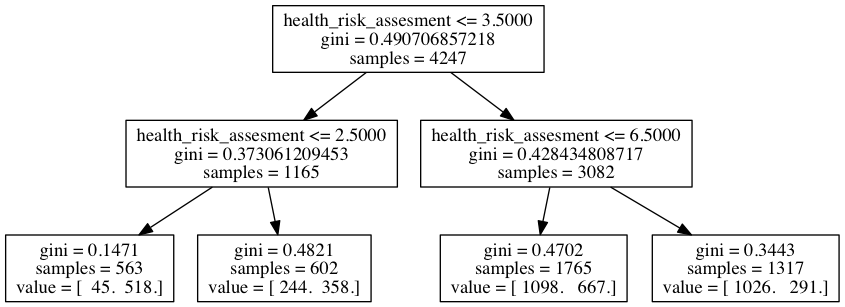

In [48]:
#Examine Decision Tree. 
dtree=DecisionTreeClassifier(random_state=0, max_depth=2)
data=df.as_matrix()
xdata=data[:,:-1]
ydata=data[:,-1]
dtree.fit(xdata,ydata)
dot_data = StringIO()
#List Headers
new_headers= list(df.columns.values)
export_graphviz(dtree, feature_names=new_headers[:-1], out_file=dot_data)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png()) 

#The Decision tree shows labels that point to the left so at the top node if the health risk assesment
#was less than 3.5 you move left. As you can see most low risk patients are succeeding and high risk
#patients are failing.

In [59]:
#In reality we would need to create a training dataset and a testing dataset
#With more time I would separate training and testing data for this example and the later models
#Check Error
metrics.mean_absolute_error(ydata,dtree.predict(xdata))

#This error is pretty high. With a higher depth decision tree accuracy does not improve.

0.29361902519425476

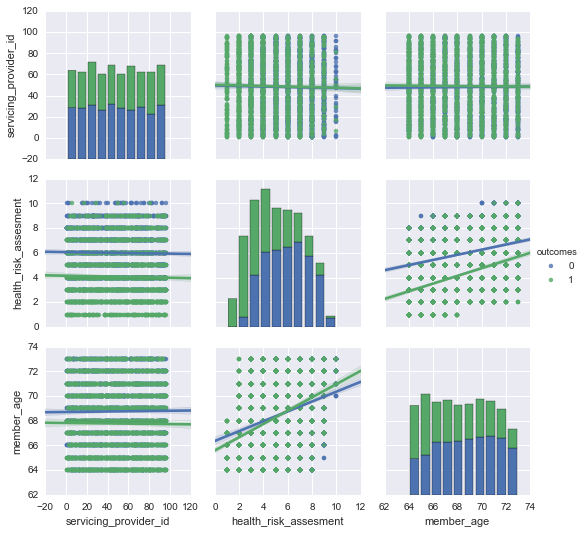

In [60]:
seaborn.pairplot(df, vars=['servicing_provider_id', 'health_risk_assesment', 'member_age'],
...                  kind='reg', hue='outcomes')

#In the pairplots green shows successful outcomes and blue shows failures
#To me the interesting pairplots were the middle histogram of health risk assesments which
#verify the above trend and the bottom right histogram which shows slightly more success in lower
#age and slightly more failures as percentage in higher age

In [61]:
#Take the mean outcome for each physician and sort by the best outcomes
df_sorted=df.groupby('servicing_provider_id', as_index=False).mean().sort('outcomes')

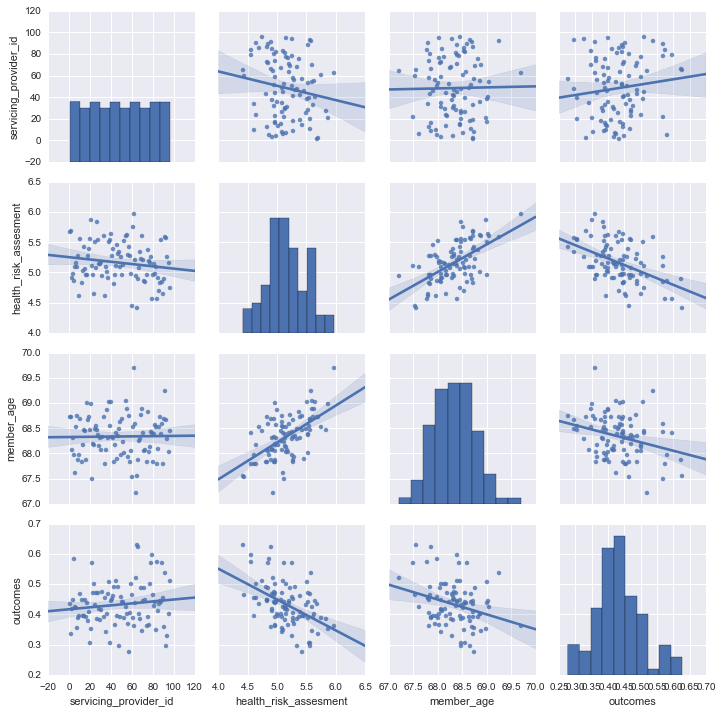

In [62]:
#Plot the averaged data grouped by physician so each point on the scatter plot represents one physician
#Looks like there inverse relationship between health risk assesment and success rate
#And potentially an inverese relationship between member age and sucess rate
#The histograms by outcome and feature do not seem to me to deviate too far from normal
seaborn.pairplot(df_sorted, vars=['servicing_provider_id', 'health_risk_assesment', 'member_age','outcomes'],kind='reg')

In [67]:
#Anova to look at interactions shows high probability of health_risk_assesment influencing outcomes 
#as well as interaction between health risk assesment and member age
#and interaction between health risk assesment and member sex
#Anova shows insignificant influence of servicing provider ID
outcomes_lm = ols("outcomes ~ C(servicing_provider_id) + C(servicing_provider_id)*health_risk_assesment + C(servicing_provider_id)*member_age + C(servicing_provider_id)*health_risk_assesment*member_age + member_sex + C(servicing_provider_id)*member_sex*health_risk_assesment", df).fit()
table1 = anova_lm(outcomes_lm)
print table1

TypeError: 'float' object is not callable

In [63]:
#Check number of records for each physician
df['servicing_provider_id'].value_counts()

38    61
67    60
18    58
68    57
39    56
94    55
21    54
90    53
6     52
44    52
70    52
96    51
73    49
56    49
26    49
43    49
28    49
23    49
46    48
50    48
64    48
8     48
17    48
13    48
63    48
47    47
45    47
57    47
84    47
15    47
      ..
30    42
24    42
2     42
31    41
72    41
75    41
92    41
32    40
95    40
54    40
55    40
77    40
41    40
91    39
7     38
4     38
69    37
40    36
62    36
20    36
61    36
87    36
9     36
36    35
85    34
59    34
10    33
86    30
14    28
42    26
dtype: int64

In [ ]:
#Check top 5 performing physicians
top_5_records=df_sorted['servicing_provider_id'].tail().as_matrix()

In [ ]:
#List servicing provider IDs
top_5_records

In [17]:
#Perform ttest comparing top 5 outcomes to the rest of the group outcomes
#Perform ttest comparing top 5 outcomes' health risk assesment to rest of group health risk assesment
outcomes_ttest=[]
hra_ttest=[]
for i in top_5_records:
    provider_data = df[df.servicing_provider_id != i]
    group_data = df[df.servicing_provider_id == i]
    provider_outcomes=provider_data.outcomes.as_matrix()
    group_outcomes=group_data.outcomes.as_matrix()
    outcomes_test=ttest_ind(provider_outcomes,group_outcomes)
    outcomes_ttest.append(outcomes_test)
    provider_hra=provider_data.health_risk_assesment.as_matrix()
    group_hra=group_data.health_risk_assesment.as_matrix()
    hra_test=ttest_ind(provider_hra,group_hra)
    hra_ttest.append(hra_test)

In [18]:
#Lowest p value is .009
outcomes_ttest

[Ttest_indResult(statistic=-1.9855976608106147, pvalue=0.047142251113192299),
 Ttest_indResult(statistic=-1.9905217582599573, pvalue=0.046597509050371098),
 Ttest_indResult(statistic=-2.2821277134840838, pvalue=0.022531063704022514),
 Ttest_indResult(statistic=-2.5936082750142617, pvalue=0.0095300847073459417),
 Ttest_indResult(statistic=-2.6104247183437432, pvalue=0.0090747717338662635)]

In [19]:
#Do best performers have lower average health risk assesments
hra_ttest

[Ttest_indResult(statistic=1.8641122980913949, pvalue=0.062374913928883127),
 Ttest_indResult(statistic=0.88309871236791349, pvalue=0.37723294670091068),
 Ttest_indResult(statistic=1.8641122980913949, pvalue=0.062374913928883127),
 Ttest_indResult(statistic=0.8185604958218482, pvalue=0.41308316085199304),
 Ttest_indResult(statistic=2.1761752650221187, pvalue=0.029597116006808758)]

In [20]:
#Bonferroni Correction for multiple comparisons shows p value would need to be less than .005
#To achieve significance. No doctor seems to perform significantly better than the others.
.05/(df.servicing_provider_id.nlargest(1).values[0])

0.0005208333333333333

In [35]:
#Extract member age and health risk assesment
data2=df[['member_age','health_risk_assesment']].as_matrix()

In [29]:
#Separate feature data and target outcomes
xdata=data2[:,:-1]
ydata=data2[:,-1]

In [30]:
#Fit Support Vector Machine
C=1.0
svc = svm.SVC(kernel='linear', C=C).fit(xdata, ydata)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(xdata, ydata)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(xdata, ydata)
lin_svc = svm.LinearSVC(C=C).fit(xdata, ydata)

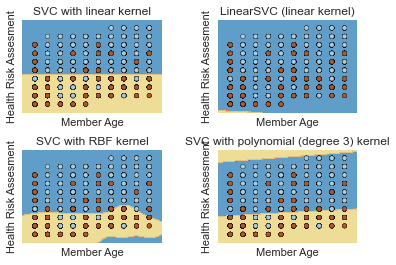

In [32]:
#Plot Support Vector Outcome
h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = xdata[:, 0].min() - 1, xdata[:, 0].max() + 1
y_min, y_max = xdata[:, 1].min() - 1, xdata[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
# title for the plots
titles = ['SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']

for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

    # Plot also the training points
    plt.scatter(xdata[:, 0], xdata[:, 1], c=ydata, cmap=plt.cm.Paired)
    plt.xlabel('Member Age')
    plt.ylabel('Health Risk Assesment')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()

([], <a list of 0 Text yticklabel objects>)

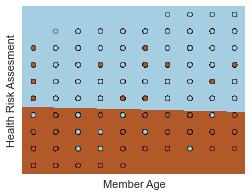

In [39]:

#Logistic Regression seems the best fit for our dataset
h = .02  # step size in the mesh

logreg = linear_model.LogisticRegression(C=1e5)

# we create an instance of Neighbours Classifier and fit the data.
logreg.fit(xdata, ydata)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x_min, x_max = xdata[:, 0].min() - .5, xdata[:, 0].max() + .5
y_min, y_max = xdata[:, 1].min() - .5, xdata[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(xdata[:, 0], xdata[:, 1], c=ydata, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Member Age')
plt.ylabel('Health Risk Assesment')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())